# Loan Classification using k-NN 

### Project Overview

The objective for this project is to utilize the K-Nearest Neighbor ML algorithm to build a classification prediction model using customer personal loan data. 

### Dataset Info:

Dataset is a random listing of personal loans along with customer information.

The 'personal_loan_info.csv'file contains a listing of customer loan info with a focus on loan status.


| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| loan_id        | Unique loan id                                                                        |
| loan_status    | Status of loan(Current, Collections, Paid, Late)                                      |
| prin_balance   | Principle loan balance                                                                |
| loan_term      | Loan origination terms(annual)                                                        |
| loan_orig_date | Origination date when the loan was generated                                          |
| loan_due_date  | Due date for next loan payment or last payment                                        |
| customer_age   | Borrower age at time of loan generation                                               |
| customer_income| Borrower income noted from loan application                                           |
| customer_gender| Borrower gender                                                                       |
| customer_edu   | Borrower latest education noted from loan application                                 |

### Python library/module setup

In [19]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### Import 'personal_loan_info.csv'

In [13]:
df = pd.read_csv(r'personal_loan_info.csv')
print(df)

     loan_id  loan_status  principal_balance  loan_term loan_orig_date  \
0          1      Current              62868         15       1/1/2014   
1          2  Collections              29152         13     12/30/2015   
2          3         Paid              69370         13     10/11/2015   
3          4         Late              67059         14      6/30/2015   
4          5      Current              78181         13      3/16/2016   
..       ...          ...                ...        ...            ...   
123      124         Late              47660          8      8/29/2015   
124      125      Current              38488         13      2/23/2016   
125      126  Collections               1222         14      1/27/2015   
126      127         Paid              20390          8      1/30/2015   
127      128         Late              54678          6      5/23/2015   

    loan_due_date  customer_age customer_gender  customer_income customer_edu  
0        2/6/2020            38

In [14]:
df.shape

(128, 10)

### Convert csv date fields to datetime format

In [15]:
df['loan_orig_date'] = pd.to_datetime(df['loan_orig_date'])
df['loan_due_date'] = pd.to_datetime(df['loan_due_date'])
df.head()

loan_id  loan_status  principal_balance  loan_term loan_orig_date  \
0        1      Current              62868         15     2014-01-01   
1        2  Collections              29152         13     2015-12-30   
2        3         Paid              69370         13     2015-10-11   
3        4         Late              67059         14     2015-06-30   
4        5      Current              78181         13     2016-03-16   

  loan_due_date  customer_age customer_gender  customer_income customer_edu  
0    2020-02-06            38               F            38877  High School  
1    2016-12-29            46               F            13082   Associates  
2    2020-01-27            51               F            49742     Bachelor  
3    2020-01-07            22               F            50453      Masters  
4    2020-02-06            59               F            26114   HighSchool

### Data Inspection

In [17]:
df.describe()

loan_id  principal_balance   loan_term  customer_age  \
count  128.000000          128.00000  128.000000     128.00000   
mean    64.500000        42662.03125    8.648438      44.46875   
std     37.094474        22042.35593    3.782658      13.39934   
min      1.000000         1222.00000    3.000000      22.00000   
25%     32.750000        23065.50000    5.000000      33.75000   
50%     64.500000        45162.50000    8.000000      44.50000   
75%     96.250000        60372.75000   12.000000      55.00000   
max    128.000000        79856.00000   15.000000      68.00000   

       customer_income  
count       128.000000  
mean      54991.718750  
std       26158.223092  
min       10279.000000  
25%       33198.500000  
50%       50735.000000  
75%       77374.500000  
max       99997.000000

In [45]:
(df.dtypes)

loan_id                       int64
loan_status                  object
principal_balance             int64
loan_term                     int64
loan_orig_date       datetime64[ns]
loan_due_date        datetime64[ns]
customer_age                  int64
customer_gender              object
customer_income               int64
customer_edu                 object
dtype: object

Check for missing values

In [42]:
missing_count = df.isnull().sum()/len(df)*100
print(missing_count)

loan_id              0.0
loan_status          0.0
principal_balance    0.0
loan_term            0.0
loan_orig_date       0.0
loan_due_date        0.0
customer_age         0.0
customer_gender      0.0
customer_income      0.0
customer_edu         0.0
dtype: float64


Observation: no missing values within the dataset

In [18]:
df['loan_status'].value_counts()

Current        32
Paid           32
Late           32
Collections    32
Name: loan_status, dtype: int64

### Visualize loan data

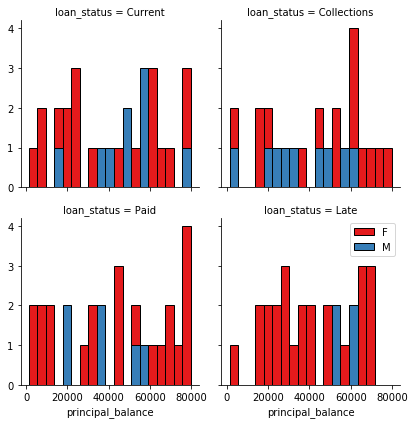

In [35]:
bins = np.linspace(df.principal_balance.min(), df.principal_balance.max(), 20)
g = sns.FacetGrid(df, col='loan_status', hue='customer_gender', palette='Set2', col_wrap=2)
g.map(plt.hist, 'principal_balance', bins=bins, ec='k')
g.axes[-1].legend()
plt.show()

Observation: equal distributions for most of the loan status, with slightly more female accounts in the 'Paid' and 'Late' status.

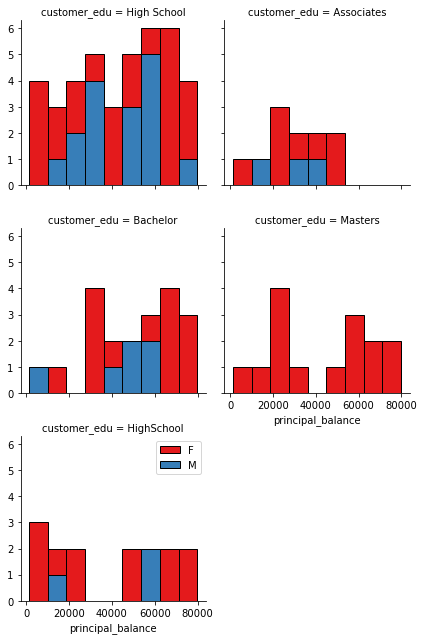

In [39]:
bins = np.linspace(df.principal_balance.min(), df.principal_balance.max(), 10)
g = sns.FacetGrid(df, col='customer_edu', hue='customer_gender', palette='Set1', col_wrap=2)
g.map(plt.hist, 'principal_balance', bins=bins, ec='k')
g.axes[-1].legend()
plt.show()

Observation: equal distributions for customer education being High School, only customers with Masters education are female.

In [41]:
df.groupby(['customer_gender'])['loan_status'].value_counts(normalize=True)

customer_gender  loan_status
F                Late           0.280000
                 Paid           0.260000
                 Collections    0.230000
                 Current        0.230000
M                Collections    0.321429
                 Current        0.321429
                 Paid           0.214286
                 Late           0.142857
Name: loan_status, dtype: float64

Observation: distributions look somewhat evenly spread out with males showing half as late as females...but higher volumes in 'Collections'

### Feature Processing

Create new dataframe with interval features only

In [70]:
df_int = df[['principal_balance','loan_term','customer_age','customer_income']]

Convert the categorical features to binary and append to df_int, create new dataframe for features

In [71]:
feature = pd.concat([df_int,
                     pd.get_dummies(df['loan_status']),
                     pd.get_dummies(df['customer_gender']),
                     pd.get_dummies(df['customer_edu'])]
                     ,axis=1)

Evaluate feature dataset and validate cat features were converted

In [72]:
feature

principal_balance  loan_term  customer_age  customer_income  Collections  \
0                62868         15            38            38877            0   
1                29152         13            46            13082            1   
2                69370         13            51            49742            0   
3                67059         14            22            50453            0   
4                78181         13            59            26114            0   
..                 ...        ...           ...              ...          ...   
123              47660          8            43            45650            0   
124              38488         13            53            19949            0   
125               1222         14            50            20216            1   
126              20390          8            36            31523            0   
127              54678          6            53            57710            0   

     Current  Late  Paid  F  M  Associates  Bachelor  High School  HighSchool  \
0          1     0     0  1  0           0         0            1           0   
1          0     0     0  1  0           1         0            0           0   
2          0     0     1  1  0           0         1            0           0   
3          0     1     0  1  0           0         0            0           0   
4          1     0     0  1  0           0         0            0           1   
..       ...   ...   ... .. ..         ...       ...          ...         ...   
123        0     1     0  1  0           0         0            1           0   
124        1     0     0  1  0           0         0            1           0   
125        0     0     0  1  0           0         0            1           0   
126        0     0     1  0  1           0         0            1           0   
127        0     1     0  0  1           0         0            1           0   

     Masters  
0          0  
1          0  
2          0  
3          1  
4          0  
..       ...  
123        0  
124        0  
125        0  
126        0  
127        0  

[128 rows x 15 columns]

### Correlation Analysis - Features

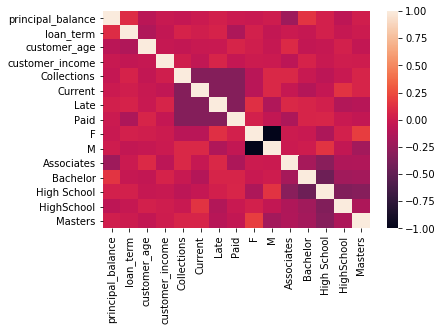

In [73]:
corr = feature.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Observation: Features show relative importance but no features truly stand out as significantly important

### Define Feature Selection: X, y

In [74]:
X = feature
X

principal_balance  loan_term  customer_age  customer_income  Collections  \
0                62868         15            38            38877            0   
1                29152         13            46            13082            1   
2                69370         13            51            49742            0   
3                67059         14            22            50453            0   
4                78181         13            59            26114            0   
..                 ...        ...           ...              ...          ...   
123              47660          8            43            45650            0   
124              38488         13            53            19949            0   
125               1222         14            50            20216            1   
126              20390          8            36            31523            0   
127              54678          6            53            57710            0   

     Current  Late  Paid  F  M  Associates  Bachelor  High School  HighSchool  \
0          1     0     0  1  0           0         0            1           0   
1          0     0     0  1  0           1         0            0           0   
2          0     0     1  1  0           0         1            0           0   
3          0     1     0  1  0           0         0            0           0   
4          1     0     0  1  0           0         0            0           1   
..       ...   ...   ... .. ..         ...       ...          ...         ...   
123        0     1     0  1  0           0         0            1           0   
124        1     0     0  1  0           0         0            1           0   
125        0     0     0  1  0           0         0            1           0   
126        0     0     1  0  1           0         0            1           0   
127        0     1     0  0  1           0         0            1           0   

     Masters  
0          0  
1          0  
2          0  
3          1  
4          0  
..       ...  
123        0  
124        0  
125        0  
126        0  
127        0  

[128 rows x 15 columns]

In [75]:
y = df['loan_status'].values
y[0:4]

array(['Current', 'Collections', 'Paid', 'Late'], dtype=object)

### Train / Test Split

Partition the data into a train and test set for evaluation

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (102, 15) (102,)
Test set: (26, 15) (26,)


In [77]:
X_train

principal_balance  loan_term  customer_age  customer_income  Collections  \
92               79856          5            36            77359            0   
10               59824         14            41            48784            0   
116              14824         13            65            72354            0   
13               46711          3            23            30678            1   
15               23312          3            60            34113            0   
..                 ...        ...           ...              ...          ...   
1                29152         13            46            13082            1   
69               37760          5            54            66644            1   
55               39880         11            37            70074            0   
46               55291          3            63            10279            0   
122              17833          9            44            62976            0   

     Current  Late  Paid  F  M  Associates  Bachelor  High School  HighSchool  \
92         1     0     0  1  0           0         0            0           0   
10         0     0     1  1  0           0         1            0           0   
116        1     0     0  1  0           0         0            1           0   
13         0     0     0  1  0           1         0            0           0   
15         0     1     0  1  0           1         0            0           0   
..       ...   ...   ... .. ..         ...       ...          ...         ...   
1          0     0     0  1  0           1         0            0           0   
69         0     0     0  1  0           0         1            0           0   
55         0     1     0  1  0           1         0            0           0   
46         0     0     1  0  1           0         0            1           0   
122        0     0     1  0  1           0         0            1           0   

     Masters  
92         1  
10         0  
116        0  
13         0  
15         0  
..       ...  
1          0  
69         0  
55         0  
46         0  
122        0  

[102 rows x 15 columns]

### Normalize data and Scale

In [78]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [86]:
print("X_train values:", X_train[0:3])
print("X_test values:", X_test[0:3])

X_train values: [[ 1.68898891 -0.87566673 -0.64001092  0.83540439 -0.6         1.75499288
  -0.6        -0.5395732   0.5395732  -0.5395732  -0.31108551 -0.5395732
  -0.87098834 -0.38218767  2.61651559]
 [ 0.77162996  1.5311059  -0.26654917 -0.25475357 -0.6        -0.56980288
  -0.6         1.85331665  0.5395732  -0.5395732  -0.31108551  1.85331665
  -0.87098834 -0.38218767 -0.38218767]
 [-1.28913045  1.26368672  1.52606723  0.64445984 -0.6         1.75499288
  -0.6        -0.5395732   0.5395732  -0.5395732  -0.31108551 -0.5395732
   1.14812099 -0.38218767 -0.38218767]]
X_test values: [[-0.60083647  0.19400999  0.55506668 -0.34204251  1.66666667 -0.56980288
  -0.6        -0.5395732  -1.85331665  1.85331665  3.21455025 -0.5395732
  -0.87098834 -0.38218767 -0.38218767]
 [-1.78036994 -0.34082837  1.52606723  1.1823474  -0.6         1.75499288
  -0.6        -0.5395732   0.5395732  -0.5395732   3.21455025 -0.5395732
  -0.87098834 -0.38218767 -0.38218767]
 [ 0.82310318  0.46142918 -1.46162677

Observation: data has scaled and is ready for Classification

### Classification using K nearest neighbor (KNN)

Import Classifier from sklearn.neighbors

In [87]:
from sklearn.neighbors import KNeighborsClassifier

### Train Model using cluster param (k=)

In [96]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

### Predict Model

In [97]:
yhat = neigh.predict(X_test)
yhat[0:4]

array(['Collections', 'Current', 'Collections', 'Collections'],
      dtype=object)

### Evaluate Accuracy

Calculate model accuracy using train and test set to determine how closely the real labels and predicted labels match.

In [105]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.9901960784313726
Test set Accuracy:  1.0


Observation: initial accuracy reflects high model accuracy.

Modify cluster grouping value (Ks=) to evalute if alternate cluster values define a better fit using a for loop to iterate through cluster values starting with 10 and decreasing.  

In [101]:
Ks = 10
mean_accuracy = np.zeros((Ks-1))
std_accuracy = np.zeros((Ks-1))
ConfusionMatrixx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_accuracy[n-1] = metrics.accuracy_score(y_test, yhat)
    std_accuracy[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print("Mean Accuracy: ", mean_accuracy)

Mean Accuracy:  [0.92307692 0.84615385 0.88461538 0.84615385 0.88461538 0.88461538
 0.92307692 0.96153846 1.        ]


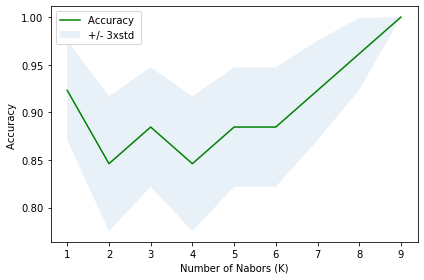

In [104]:
plt.plot(range(1,Ks),mean_accuracy,'g')
plt.fill_between(range(1,Ks),mean_accuracy - 1 * std_accuracy,mean_accuracy + 1 * std_accuracy, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

### Testing Result

Observation: The model was able to obtain 100% accuracy which is an indicator of overfitting due to the limited dataset size. Increasing the dataset size would allow us to generate a model that more closely resembles a better fitting model. 